In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

实验设计：
- 从 VisiumHD 采用 2um bin 生成 pseudo Visium
- 将 pseudo Visium 输入 iStar 进行超分，采用 VisiumHD 模式 16um bin
- VisiumHD 合并成 16um 和超分后的像素一一对应
- 计算 pcc, mse

## 一、数据准备
### 1.1 构建模拟 Visium 数据集

In [2]:
from pathlib import Path
from models import iStar
from datasets import VisiumHDData
from profiles import VisiumProfile, VisiumHDProfile

默认使用 2um bin 的数据模拟 Visium

In [3]:
visiumHD_profile_2um = VisiumHDProfile()

In [4]:
# path = '/data/datasets/Visium_HD_Human_Tonsil_Fresh_Frozen/binned_outputs/square_002um'
path = '/data/datasets/Visium_HD_Mouse_Brain_Fresh_Frozen/binned_outputs/square_002um'
# path = '/mnt/TenTA-f702/user/zhangyichi/Data/Visium_HD_Human_Tonsil_Fresh_Frozen/binned_outputs/square_002um'
# imagefile = '/data/datasets/Visium_HD_Human_Tonsil_Fresh_Frozen/Visium_HD_Human_Tonsil_Fresh_Frozen_tissue_image.tif'
imagefile = '/data/datasets/Visium_HD_Mouse_Brain_Fresh_Frozen/Visium_HD_Mouse_Brain_Fresh_Frozen_tissue_image.tif'
# imagefile = '/mnt/TenTA-f702/user/zhangyichi/Data/Visium_HD_Human_Tonsil_Fresh_Frozen/Visium_HD_Human_Tonsil_Fresh_Frozen_tissue_image.tif'
rawdata = VisiumHDData()
rawdata.load(
    path=path,
    profile=visiumHD_profile_2um,
    source_image_path=imagefile
)
rawdata.select_HVG(n_top_genes=2000,min_counts=10)

Start load
Finish load in 29.7021 s


设定 visium 配置，这里选择用于 CytAssist 仪器的 6.5 mm 捕获区域的载玻片。自定义 spot 的间距为 99，确保均在 VisiumHD 的测序范围内。

In [5]:
visium_profile = VisiumProfile(slide_serial=4, spot_step=99.0)

依据 visium 配置将 bin 加和到 spot，min_bin 指定一个 spot 至少要覆盖多少有表达的 bin。

In [6]:
emulate_visium = rawdata.HD2Visium(visium_profile, min_bin=500)

Merge the gene expression from bins to the spot
[██████████████████████████████████████████████████] 100.0%


检查模拟 Visium 位置和遮掩是否正确

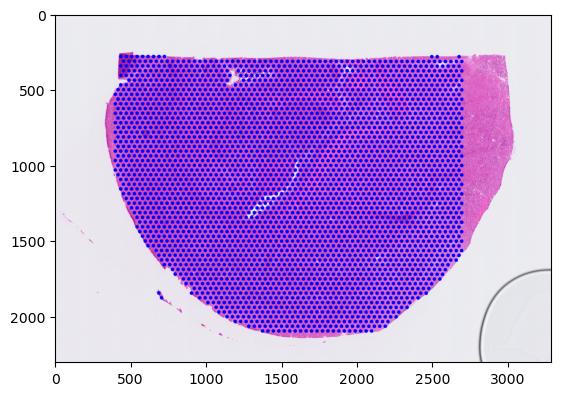

In [7]:
import cv2
import matplotlib.pyplot as plt
spot_img = emulate_visium.vision_spots(in_tissue=True, color=(0,0,255))
plt.imshow(cv2.resize(spot_img, None, fx=0.1, fy=0.1))

In [9]:
emulate_visium.save("emulate_visium_MB")

Start save
Finish save in 2.0541 s


### 1.2 使用 iStar 超分

对齐 16 um 和 2um bin，这里参考 VisiumHD 的合并方法，采取左上角对齐。 

In [11]:
# visium_profile = VisiumProfile(slide_serial=4, spot_step=99.0)
visiumHD_profile_16um = VisiumHDProfile(bin_size=16)
visiumHD_profile_2um = VisiumHDProfile(bin_size=2)

In [12]:
center = [ i/2 for i in visiumHD_profile_2um.frame]

读取模拟数据，自动遮掩，指定对齐方式

In [13]:
istar_visium = iStar()
istar_visium.load(
    path="emulate_visium_MB",
    profile=visium_profile,
    source_image_path="emulate_visium_MB/image.tif"
)
istar_visium.tissue_mask(auto_mask=True)
visiumHD_demo = istar_visium.Visium2HD(visiumHD_profile_16um, mode='manual',center=center)

Start load
Finish load in 0.2599 s


In [14]:
istar_visium.set_target_VisiumHD(visiumHD_demo)
istar_visium.save_input("istar_on_emulate_MB")

Cropping patch image of each bin
[█████████████████████████████████████████████████ ] 100.0%


In [15]:
istar_visium.load_output("istar_on_emulate_MB")

Reading iStar output
[██████████████████████████████████████████████████] 100.0%


In [16]:
superHD = istar_visium.to_VisiumHD()

Start to_VisiumHD
Finish to_VisiumHD in 4.8423 s


由于当前版本 scanpy(1.10.4) 还未支持 VisiumHD 数据。这里无法保证所采用的数据格式可以和 scanpy 完全兼容。

In [17]:
super_adata = superHD.to_anndata()
super_adata

AnnData object with n_obs × n_vars = 174724 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [18]:
super_adata.write_h5ad("super_emulate_MB.h5ad")

### 1.3 保存 16um 分辨率的真值

In [19]:
path = '/data/datasets/Visium_HD_Mouse_Brain_Fresh_Frozen/binned_outputs/square_016um'
imagefile = '/data/datasets/Visium_HD_Mouse_Brain_Fresh_Frozen/Visium_HD_Mouse_Brain_Fresh_Frozen_tissue_image.tif'
rawdata_16um = VisiumHDData()
rawdata_16um.load(
    path=path,
    profile=visiumHD_profile_16um,
    source_image_path=imagefile
)

Start load
Finish load in 18.3694 s
Unable to match the profile, transferring to the specified profile.


选择基于 2um 分辨率得到的 HVG

In [26]:
genes = super_adata.var_names
genes

Index(['Sox17', 'Oprk1', 'Vxn', 'Sulf1', 'Jph1', 'Tfap2d', 'Efhc1', 'Kcnq5',
       'Col19a1', 'Khdrbs2',
       ...
       'Dcx', 'Lhfpl1', 'Htr2c', 'Alas2', 'Gpr143', 'Cnksr2', 'Map3k15',
       'Gja6', 'Glra2', 'Tmsb4x'],
      dtype='object', length=2000)

In [27]:
rawdata_16um.require_genes(genes)

得到适用于 scanpy 分析 VisiumHD 数据的 h5ad 格式

In [28]:
raw_adata_16um = rawdata_16um.to_anndata()
raw_adata_16um

AnnData object with n_obs × n_vars = 174724 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [29]:
raw_adata_16um.write_h5ad("raw_16_MB.h5ad")

## 二、评测超分效果

In [30]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr

In [31]:
raw_adata_16um = ad.read_h5ad("raw_16_MB.h5ad")
super_adata = ad.read_h5ad("super_emulate_MB.h5ad")

/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


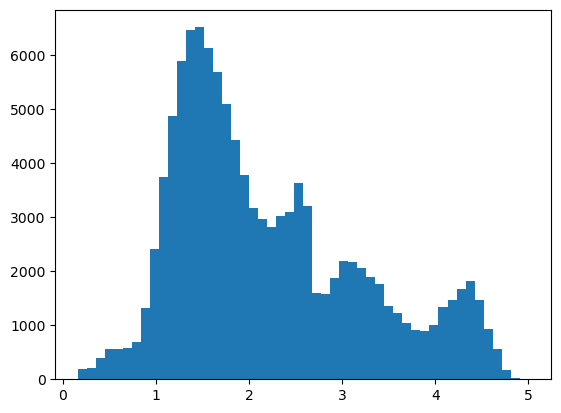

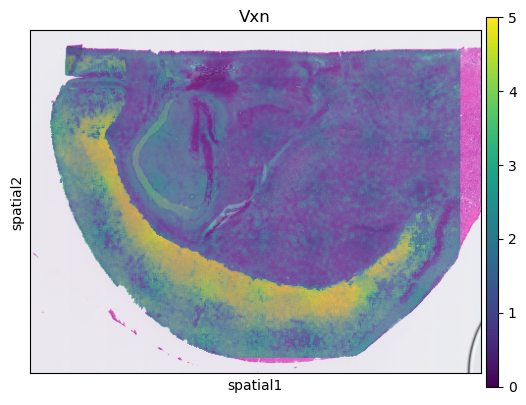

In [32]:
gene_name = "Vxn" 
adata = super_adata[super_adata.obs['in_tissue']==1]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=2000)
plt.hist(adata[:, gene_name].X.toarray().flatten(), bins=50)
plt.show()
sc.pl.spatial(
    adata,
    color=gene_name,
    vmin=0,   # 最小值
    vmax=5,   # 最大值
    color_map="viridis"
)

/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


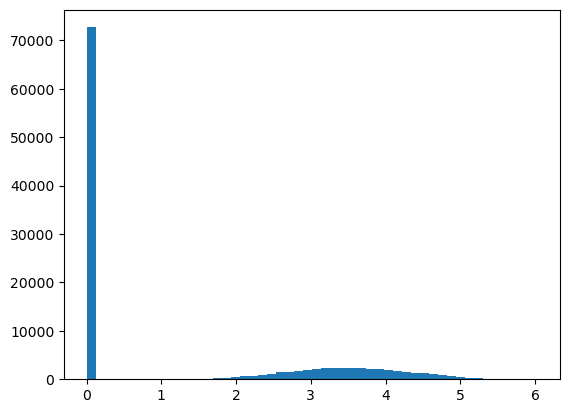

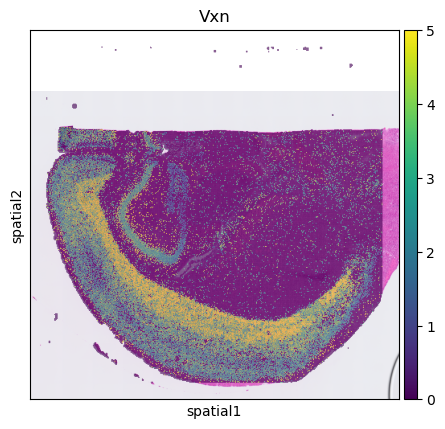

In [34]:
gene_name = "Vxn"  # 替换为你要可视化的基因名
adata = raw_adata_16um[raw_adata_16um.obs['in_tissue']==1]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
plt.hist(adata[:, gene_name].X.toarray().flatten(), bins=50)
plt.show()
sc.pl.spatial(
    adata,
    color=gene_name,
    vmin=0,   # 最小值
    vmax=5,   # 最大值
    color_map="viridis"
)

In [36]:
raw_adata_16um.to_df()

,Sox17,Oprk1,Vxn,Sulf1,Jph1,Tfap2d,Efhc1,Kcnq5,Col19a1,Khdrbs2,...,Dcx,Lhfpl1,Htr2c,Alas2,Gpr143,Cnksr2,Map3k15,Gja6,Glra2,Tmsb4x
s_016um_00000_00000-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00001-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00002-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00003-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00004-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_016um_00417_00413-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00417_00414-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00417_00415-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00417_00416-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
super_adata.to_df()

,Sox17,Oprk1,Vxn,Sulf1,Jph1,Tfap2d,Efhc1,Kcnq5,Col19a1,Khdrbs2,...,Dcx,Lhfpl1,Htr2c,Alas2,Gpr143,Cnksr2,Map3k15,Gja6,Glra2,Tmsb4x
barcode,,,,,,,,,,,,,,,,,,,,,
s_016um_00000_00000-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00001-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00002-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00003-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00000_00004-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_016um_00417_00413-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00417_00414-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_016um_00417_00415-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
import numpy as np

def compute_pcc_mse(matrix1, matrix2):
    
    n_genes = matrix1.shape[1]
    pcc_values = np.zeros(n_genes)
    mse_values = np.zeros(n_genes)
    
    for i in range(n_genes):
        col1 = matrix1[:, i].toarray().flatten()  # 转换为1D数组
        col2 = matrix2[:, i].toarray().flatten()
        
        # 计算PCC
        if np.std(col1) == 0 or np.std(col2) == 0:
            pcc_values[i] = np.nan  # 避免除零错误
        else:
            pcc_values[i], _ = pearsonr(col1, col2)

        # 计算MSE
        mse_values[i] = np.mean((col1 - col2) ** 2)

    return pcc_values, mse_values


pcc, mse = compute_pcc_mse(raw_adata_16um.X, super_adata.X)

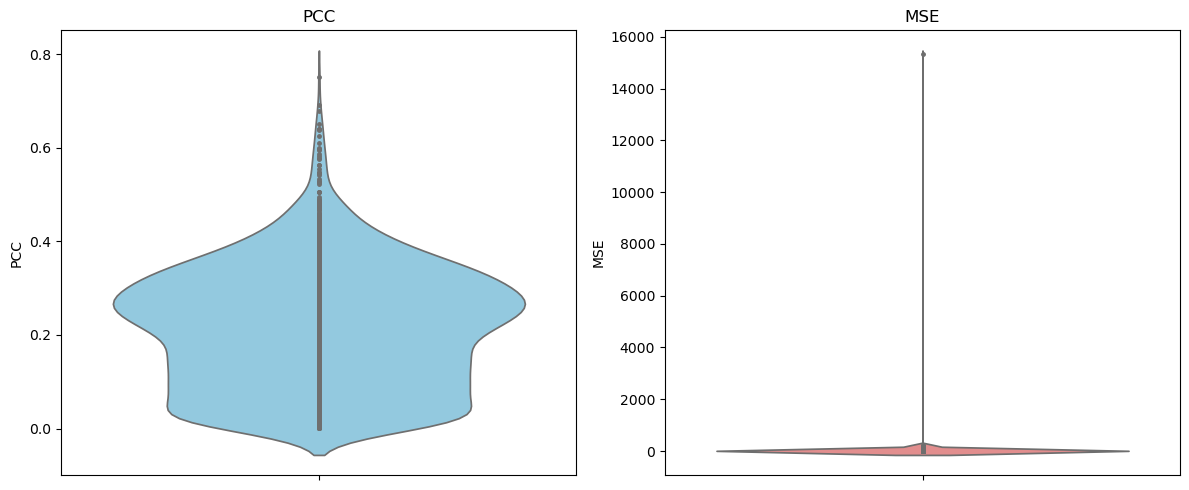

In [39]:
df = pd.DataFrame({
    "PCC": pcc,
    "MSE": mse
})

# 绘制小提琴图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(y=df["PCC"], ax=axes[0], inner="point", color="skyblue")
axes[0].set_title("PCC")
axes[0].set_ylabel("PCC")

sns.violinplot(y=df["MSE"], ax=axes[1], inner="point", color="lightcoral")
axes[1].set_title("MSE")
axes[1].set_ylabel("MSE")

plt.tight_layout()
plt.show()

In [40]:
np.mean(mse), np.mean(pcc)

(9.26971625613432, 0.21591974800938107)